In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import math
import copy
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.special import lambertw

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from abstract_gradient_training import test_metrics
from abstract_gradient_training import interval_arithmetic
from abstract_gradient_training import nominal_pass
from abstract_gradient_training.bounds import interval_bound_propagation as ibp

sys.path.append('..')
from models.deepmind import DeepMindSmall 
from datasets import oct_mnist
torch.set_printoptions(linewidth=20000)

In [2]:
results_dir = ".results/"
seed = 2
notebook_id = f"oct_sweep_v2_{seed}"
model_path = ".models/medmnist.ckpt"  # pretrained model path
draft = True  # whether to compute the full suite of results or a quicker reduced version
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

### Define the nominal config, model and dataloaders

In [3]:
batchsize = 5000
nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=0.2,
    n_epochs=2,
    forward_bound="interval",
    device="cuda:0",
    backward_bound="interval",
    loss="binary_cross_entropy",
    log_level="DEBUG",
    lr_decay=2.0,
    clip_gamma=1.0,
    # dp_sgd_sigma=1.0,
    lr_min=0.001,
    early_stopping=False,
    metadata=f"model={model_path}"
)

# get the "DeepMindSmall" model, pretrained on the MedMNIST dataset (without class 2, Drusen)
model = DeepMindSmall(1, 1)
model.load_state_dict(torch.load(model_path))
model = model.to(nominal_config.device)

# get dataloaders, train dataloader is a mix of drusen and the "healthy" class
dl_train, _ = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1], balanced=True)
_, dl_test_drusen = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[0, 1, 3])
_, dl_test_other = oct_mnist.get_dataloaders(batchsize, 1000, exclude_classes=[2])
_, dl_test_all = oct_mnist.get_dataloaders(batchsize, 1000)

### Helper functions to perform the sweep

In [4]:
def run_with_config(config):
    """If results for this configuration are already computed, load them from disk. Otherwise, run the certified
    training using AGT, then save and return the results."""
    fname = f"{results_dir}/{notebook_id}_{config.hash()}"
    if os.path.isfile(fname):  # run exists, so return the previous results
        param_l, param_n, param_u = torch.load(fname)
    else:
        # check whether the given config should be either unlearning or privacy training
        assert not (config.k_unlearn and config.k_private)
        torch.manual_seed(seed)
        if config.k_private:
            param_l, param_n, param_u = agt.privacy_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        else:
            param_l, param_n, param_u = agt.unlearning_certified_training(
                model, config, dl_train, dl_test_drusen, transform=ct_utils.propagate_conv_layers
            )
        torch.save((param_l, param_n, param_u), fname)
    return param_l, param_n, param_u

### Perform the sweep over different gamma and k values

In [5]:
privacy_results = {}  # the results dictionary will be indexed by results[k_private]
k_private_vals = list(range(0, 51, 1)) + list(range(51, 201, 5))
k_private_vals = [  0,   4,   7,  10,  13,  16,  22,  30,  40,  80,  92, 100]

config = copy.deepcopy(nominal_config)
for k_private in k_private_vals:
    config.k_private = k_private
    privacy_results[k_private] = run_with_config(config)
    

In [6]:
def compute_max_certified_k(test_batch, test_labels, privacy_results):
    """Compute the maximum k for which we can certify each data point."""
    k_max = torch.zeros_like(test_labels, device=nominal_config.device).squeeze()
    
    for k, (param_l, param_n, param_u) in privacy_results.items():
        cert = test_metrics.proportion_certified(
            param_n,
            param_l,
            param_u,
            test_batch,
            test_labels,
            model=model,
            transform=ct_utils.propagate_conv_layers,
            reduce=False,
        )  # boolean vector stating whether each test point is certified (sens=0) or not (sens=1)
        k_max = torch.max(k_max, k * cert)  # update the maximum k value which we can certify for each test point
    
    k_max = k_max + 1 # add 1 to the maximum k value to get the minimum k value which we cannot certify
    
    return k_max

In [7]:
"""Reduce noise added using the smooth sensitivity and epsilon-delta privacy"""

# Reduce the noise at a given epsilon and delta
test_point, test_label = next(iter(dl_test_all))
epsilon = 0.5
delta = 10 ** -5
beta = epsilon / (2 * math.log(2 / delta))

print(f"{epsilon = }")
print(f"{delta = }")
print(f"{beta = }")
k_max = compute_max_certified_k(test_point, test_label, privacy_results)
print(f"{k_max = }")
smooth_sens = torch.exp(-2 * beta * k_max)
print(f"{smooth_sens = }")
noise_level = (2 * smooth_sens / epsilon).clamp(max=1.0 / epsilon)
print(f"{noise_level = }")

print(
    "Noise-free accuracy",
    test_metrics.test_accuracy(
        *privacy_results[0], test_point, test_label, model=model, transform=ct_utils.propagate_conv_layers
    )[1],
)
print(
    "Acc with global sensitivity",
    test_metrics.test_accuracy(
        *privacy_results[0],
        test_point,
        test_label,
        model=model,
        transform=ct_utils.propagate_conv_layers,
        noise_level=1 / epsilon,
    )[1],
)
print(
    f"Acc with smooth sensitivity",
    test_metrics.test_accuracy(
        *privacy_results[0],
        *next(iter(dl_test_all)),
        model=model,
        transform=ct_utils.propagate_conv_layers,
        noise_level=noise_level,
    )[1],
)

epsilon = 0.5
delta = 1e-05
beta = 0.02048160839773055
k_max = tensor([  1,  23,   1,  17,  41, 101, 101,  41,  23,   1,  41,  81, 101,  81, 101,  93,  41,  41,  41,  93,  41, 101,  93, 101, 101,  41,  41,  81,   1,  41, 101,   1,  41,  41,  31,   5,  93,  41,  23,  17, 101,  41, 101,   5,  17, 101,  31,  81, 101,  41,  17,  41, 101,   5, 101, 101,  41, 101,  41,  41,  41, 101, 101,   8,  14,  81,  11, 101,  93,  41,  23,  81,  93,   8,  41,  41,  41, 101, 101,  17,  31,  41,  23, 101, 101, 101, 101, 101,   5,  41,  41,  11, 101, 101, 101,   1,  41,  81, 101,   8,  17,  41, 101,   1,   1, 101,  23,   8,  14,  23, 101, 101, 101,  41, 101,  41,  23,   8,   5, 101,  23,  31, 101,  31, 101,  14, 101, 101, 101,  23,  14, 101, 101,   1,  23,  41,   8,  17,  41,  41,   5,  41, 101,  11,  41,   1,  11,   1,  41,  41, 101,  41, 101,  41,  11, 101,  11,  41, 101,  23, 101,  23,  41, 101,  11,  31,  41,  11,  11, 101,  11,   8, 101,  23,   8,  23,  41, 101,  31,   1, 101, 101, 101,  41, 101,  17,

In [8]:
def get_cauchy_noise_level(test_batch, test_labels, privacy_results, epsilon):
    """Compute the noise level for the Cauchy mechanism."""
    k_max = compute_max_certified_k(test_batch, test_labels, privacy_results)
    gamma = 2  # for Cauchy distribution
    beta = epsilon / (2 * (gamma + 1)) - 1e-7
    smooth_sens = torch.exp(-2 * beta * k_max)
    noise_level = 2 * (gamma + 1) * smooth_sens / epsilon
    return noise_level

def compute_local_epsilons(test_batch, test_labels, privacy_results, epsilon, delta):
    """Compute the local epsilon for each test point, via the smooth sensitivity bound."""
    k_max = compute_max_certified_k(test_batch, test_labels, privacy_results)
    
    k_max = k_max.cpu().numpy()
    local_epsilons = math.log(2 / delta) * lambertw(2 * epsilon * k_max / math.log(2 / delta)) / k_max
    local_epsilons = local_epsilons.real  # should always be real, but output of lambertw is complex
    local_epsilons = torch.tensor(local_epsilons, device=nominal_config.device)
    local_epsilons = local_epsilons.clamp(max=epsilon)
    return local_epsilons


In [9]:
"""Reduce noise added using the smooth sensitivity and epsilon privacy"""

noise_free_acc = test_metrics.test_accuracy(
        *privacy_results[0], test_point, test_label, model=model, transform=ct_utils.propagate_conv_layers
    )[1]

print(
    "Noise-free accuracy",
    noise_free_acc,
)

# Reduce the noise at a given epsilon and delta

epsilons = 0.1, 0.2, 0.5, 1.0, 5.0
n_runs = 100

for epsilon in epsilons:
    noise_level = get_cauchy_noise_level(test_point, test_label, privacy_results, epsilon) + 1e-8
    private_accs_cauchy = []
    private_accs_laplace = []
    for _ in range(n_runs):
        private_accs_cauchy.append(
            test_metrics.test_accuracy(
                *privacy_results[0],
                test_point,
                test_label,
                model=model,
                transform=ct_utils.propagate_conv_layers,
                noise_level=noise_level,
                noise_type="cauchy",
            )[1]
        )
        private_accs_laplace.append(
            test_metrics.test_accuracy(
                *privacy_results[0],
                test_point,
                test_label,
                model=model,
                transform=ct_utils.propagate_conv_layers,
                noise_level=1 / epsilon,
                noise_type="laplace",
            )[1]
        )
    print(
        f"Epsilon, Global (Laplace), Smooth (Cauchy):"
        f"{epsilon} &  {100 * np.mean(private_accs_laplace):.3g} $\pm$ {100 * np.std(private_accs_laplace):.3g}"
        f"& {100 * np.mean(private_accs_cauchy):.3g} $\pm$ {100 * np.std(private_accs_cauchy):.3g}"
    )

Noise-free accuracy 0.8730000257492065
Epsilon, Global (Laplace), Smooth (Cauchy):0.1 &  51.8 $\pm$ 1.45& 53.4 $\pm$ 1.59
Epsilon, Global (Laplace), Smooth (Cauchy):0.2 &  53.7 $\pm$ 1.66& 70.6 $\pm$ 1.23
Epsilon, Global (Laplace), Smooth (Cauchy):0.5 &  58.3 $\pm$ 1.48& 84.8 $\pm$ 0.78
Epsilon, Global (Laplace), Smooth (Cauchy):1.0 &  64.6 $\pm$ 1.42& 87 $\pm$ 0.502
Epsilon, Global (Laplace), Smooth (Cauchy):5.0 &  84.1 $\pm$ 0.628& 87.4 $\pm$ 0.236


In [10]:
epsilons = torch.logspace(-2, 1, 40)
print(epsilons)

cauchy_means = []
cauchy_stds = []
laplace_means = []
laplace_stds = []

n_runs = 100

for epsilon in epsilons:
    noise_level = get_cauchy_noise_level(test_point, test_label, privacy_results, epsilon) + 1e-8
    private_accs_cauchy = []
    private_accs_laplace = []
    for _ in range(n_runs):
        private_accs_cauchy.append(
            test_metrics.test_accuracy(
                *privacy_results[0],
                test_point,
                test_label,
                model=model,
                transform=ct_utils.propagate_conv_layers,
                noise_level=noise_level,
                noise_type="cauchy",
            )[1]
        )
        private_accs_laplace.append(
            test_metrics.test_accuracy(
                *privacy_results[0],
                test_point,
                test_label,
                model=model,
                transform=ct_utils.propagate_conv_layers,
                noise_level=float(1 / epsilon),
                noise_type="laplace",
            )[1]
        )
    cauchy_means.append(np.mean(private_accs_cauchy))
    cauchy_stds.append(np.std(private_accs_cauchy))
    laplace_means.append(np.mean(private_accs_laplace))
    laplace_stds.append(np.std(private_accs_laplace))
    

tensor([1.0000e-02, 1.1938e-02, 1.4251e-02, 1.7013e-02, 2.0309e-02, 2.4245e-02, 2.8943e-02, 3.4551e-02, 4.1246e-02, 4.9239e-02, 5.8780e-02, 7.0170e-02, 8.3768e-02, 1.0000e-01, 1.1938e-01, 1.4251e-01, 1.7013e-01, 2.0309e-01, 2.4245e-01, 2.8943e-01, 3.4551e-01, 4.1246e-01, 4.9239e-01, 5.8780e-01, 7.0170e-01, 8.3768e-01, 1.0000e+00, 1.1938e+00, 1.4251e+00, 1.7013e+00, 2.0309e+00, 2.4245e+00, 2.8943e+00, 3.4551e+00, 4.1246e+00, 4.9239e+00, 5.8780e+00, 7.0170e+00, 8.3768e+00, 1.0000e+01])


In [11]:
"""Add constant noise, and compute the local epsilons."""

test_point, test_label = next(iter(dl_test_all))
delta = 10 ** -5

local_eps = []

for epsilon in epsilons:
    epsilon = float(epsilon)
    local_epsilons = compute_local_epsilons(test_point, test_label, privacy_results, epsilon, delta)
    local_eps.append(local_epsilons.mean().item())

print(epsilons)
print(local_eps)

tensor([1.0000e-02, 1.1938e-02, 1.4251e-02, 1.7013e-02, 2.0309e-02, 2.4245e-02, 2.8943e-02, 3.4551e-02, 4.1246e-02, 4.9239e-02, 5.8780e-02, 7.0170e-02, 8.3768e-02, 1.0000e-01, 1.1938e-01, 1.4251e-01, 1.7013e-01, 2.0309e-01, 2.4245e-01, 2.8943e-01, 3.4551e-01, 4.1246e-01, 4.9239e-01, 5.8780e-01, 7.0170e-01, 8.3768e-01, 1.0000e+00, 1.1938e+00, 1.4251e+00, 1.7013e+00, 2.0309e+00, 2.4245e+00, 2.8943e+00, 3.4551e+00, 4.1246e+00, 4.9239e+00, 5.8780e+00, 7.0170e+00, 8.3768e+00, 1.0000e+01])
[0.009999999776482582, 0.011937766335904598, 0.014251026324927807, 0.017012542113661766, 0.020309176295995712, 0.02424461953341961, 0.028942661359906197, 0.034551072865724564, 0.041246265172958374, 0.04923882707953453, 0.058780159801244736, 0.07017038017511368, 0.08376776427030563, 0.09768702390344644, 0.11340426145649102, 0.13150643132880457, 0.15252855995995343, 0.17698870592914018, 0.20194531137777486, 0.22947310734068616, 0.2595127035725322, 0.2922246812675993, 0.32821626977216184, 0.36637152987631166,

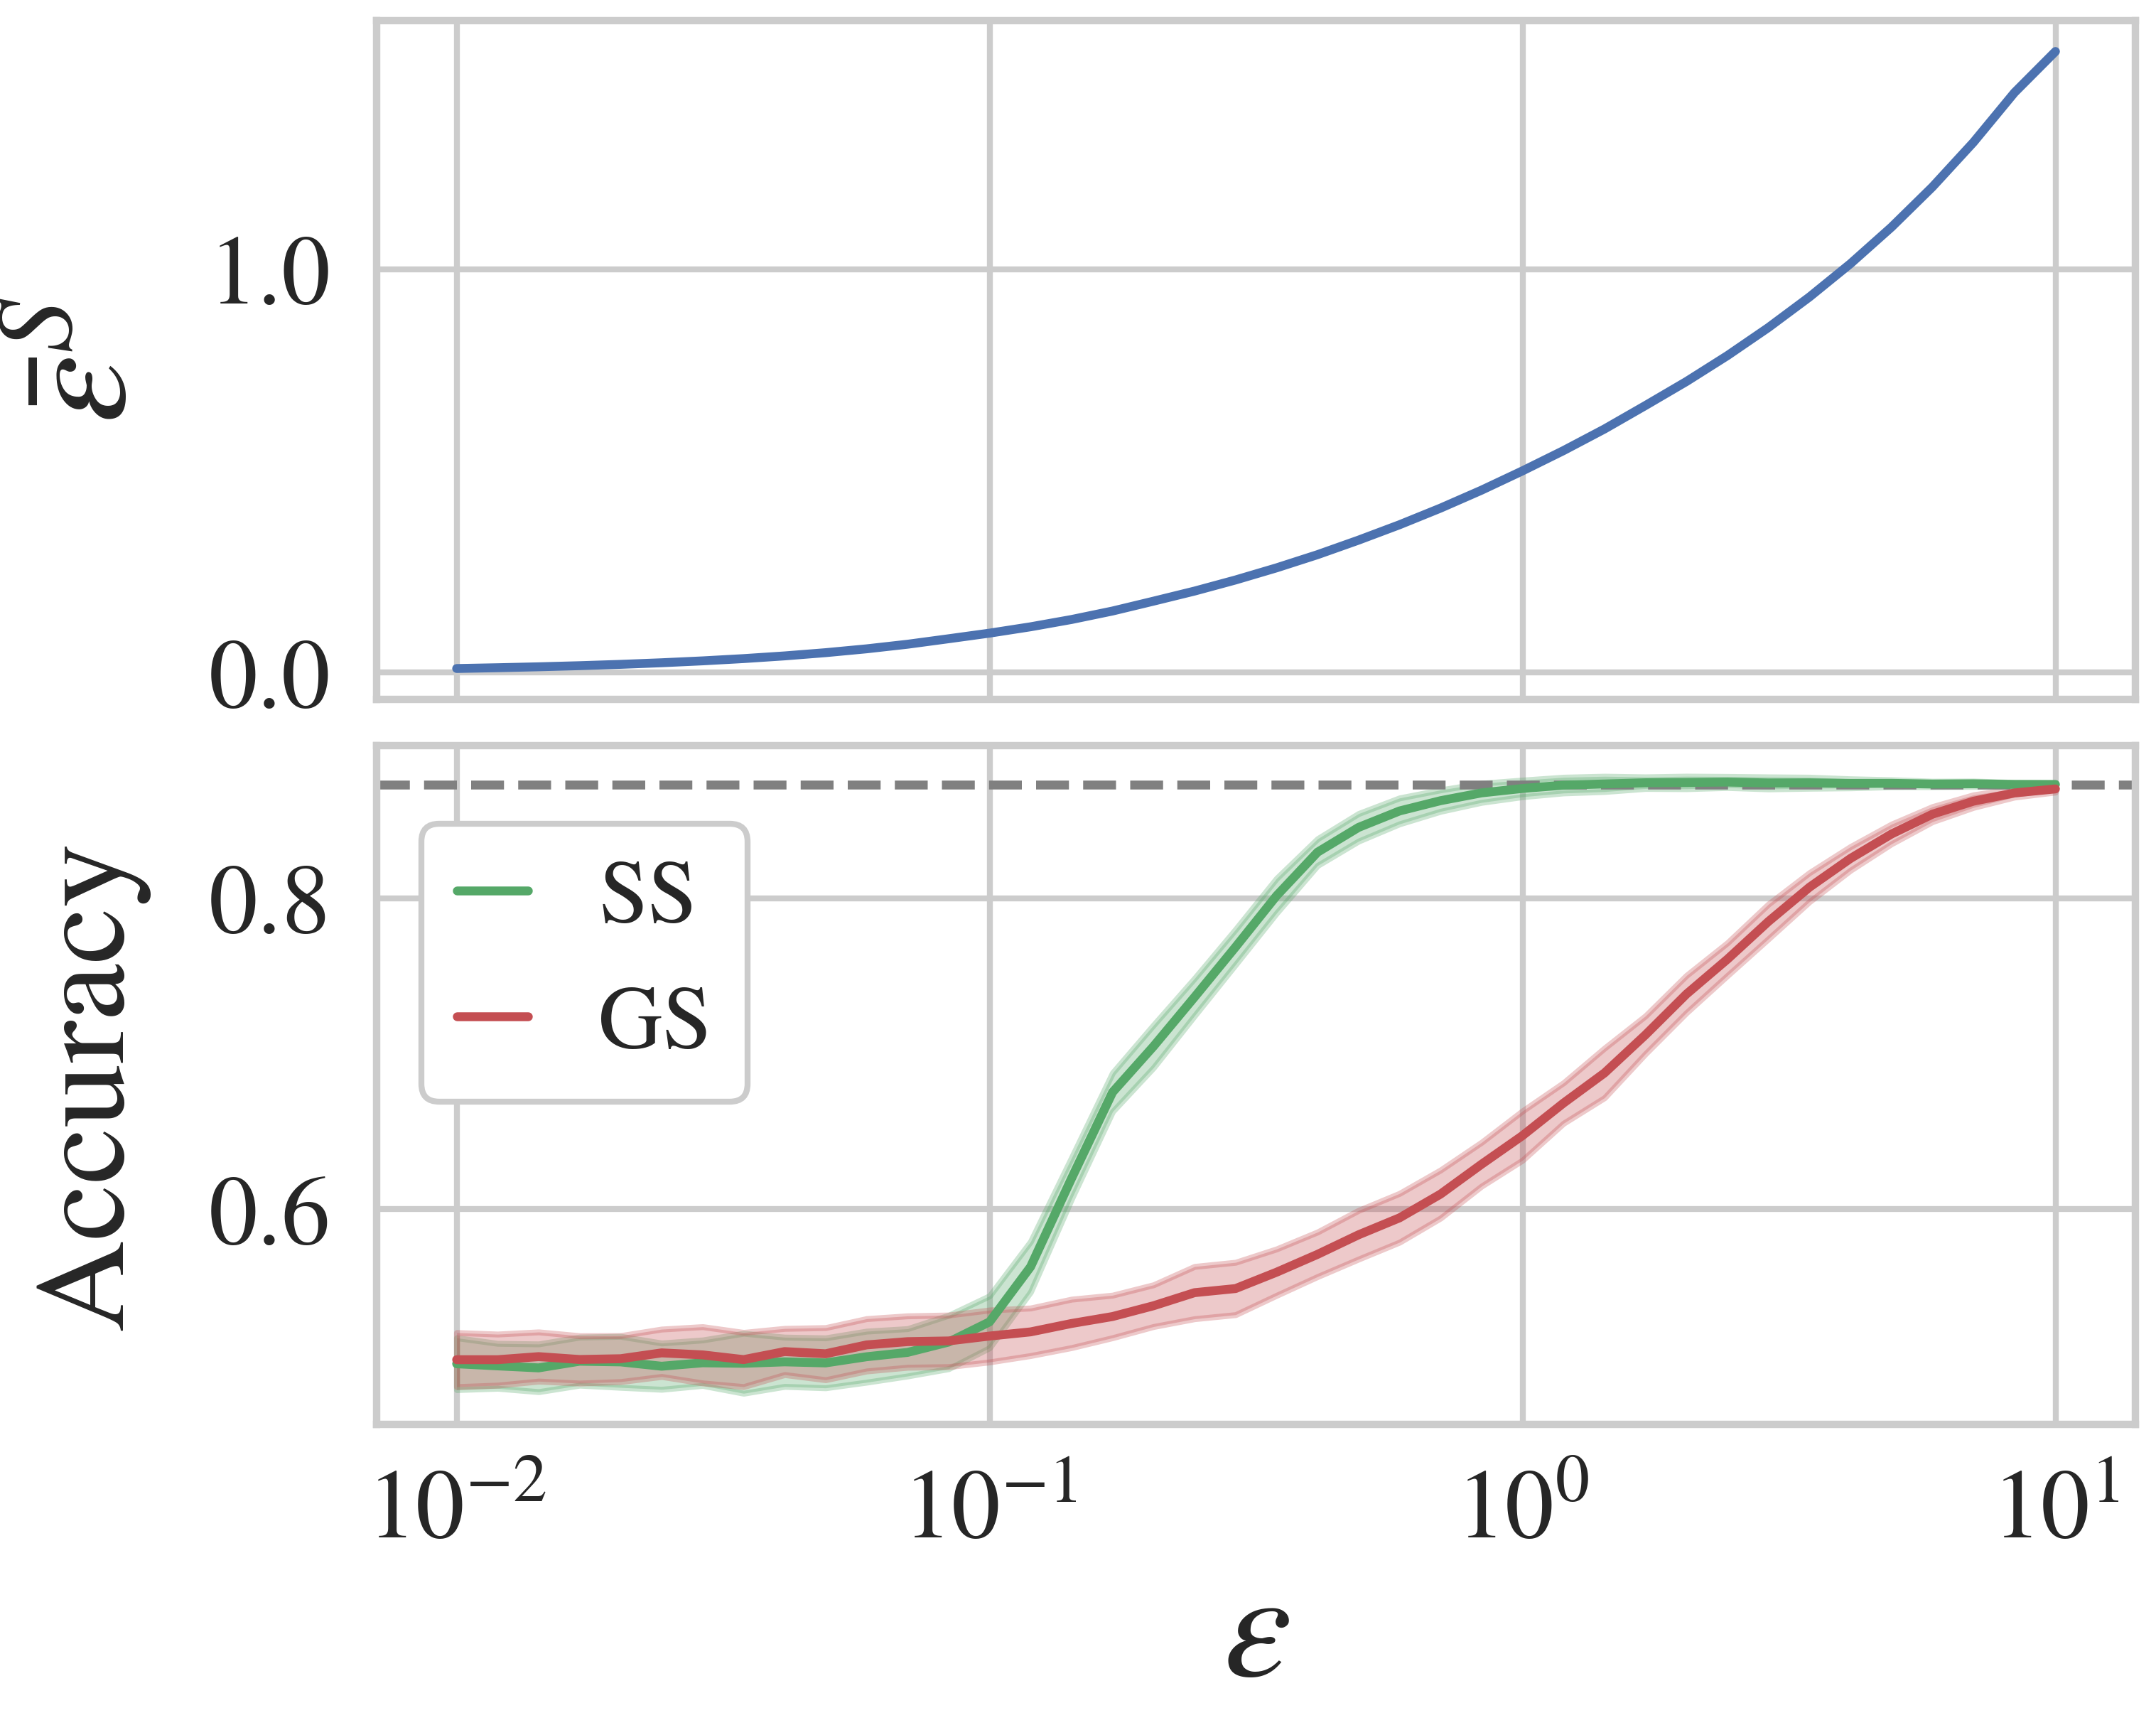

In [12]:
barcolor = sns.color_palette("deep")[0]
laplacecolor = sns.color_palette("deep")[3]
cauchycolor = sns.color_palette("deep")[2]

sns.set_theme(context="poster", style="whitegrid", font_scale=1.5)
mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"

# fig, axs = plt.subplots(2, 1, figsize=(12, 6), layout="constrained", sharex=True, dpi=300)

fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained", sharex=True, dpi=300)

axs[0].set_xscale("log")
axs[1].set_xlabel("$\epsilon$", fontsize="x-large")

# axs[0].plot(epsilons, np.array(local_eps) / np.array(epsilons), c=barcolor)
axs[0].plot(epsilons, np.array(local_eps), c=barcolor)

axs[1].set_ylabel("Accuracy", fontsize="large", labelpad=20)
axs[0].set_ylabel(r"${\bar{\epsilon}^S}$", fontsize="x-large", labelpad=40, va="center")

axs[1].axhline(noise_free_acc, c="gray", linestyle="--")
axs[1].plot(epsilons, cauchy_means, c=cauchycolor, label="SS")
axs[1].fill_between(
    epsilons,
    np.array(cauchy_means) - np.array(cauchy_stds),
    np.array(cauchy_means) + np.array(cauchy_stds),
    color=cauchycolor,
    alpha=0.3,
)
axs[1].plot(epsilons, laplace_means, c=laplacecolor, label="GS")
axs[1].fill_between(
    epsilons,
    np.array(laplace_means) - np.array(laplace_stds),
    np.array(laplace_means) + np.array(laplace_stds),
    color=laplacecolor,
    alpha=0.3,
)
axs[1].legend(loc="upper left", handlelength=0.8, framealpha=1.0, bbox_to_anchor=(0.0, 0.95), fontsize="small")
axs[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
axs[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.1f'))
plt.savefig(".figures/octmnist_ss_usage.pdf", bbox_inches="tight", dpi=300)